# How much money Lending Club has lost through loan defaultation?

In order to find out the answer, we look through the original data file and will estimate _loss_ for defaulted loans.

_loss_ is defined as the difference between the expected amount and total payment.
The expected amount is estimated by the loan term multiplied by monthly installment. The total payment as well as the date of last payment both are available. 



In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer

import datetime

import pickle

In [143]:
filepath = "C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\accepted_2007_to_2018Q4.csv"
df = pd.read_csv(filepath)

In [144]:
# Defining a new column 'new_status' and combine 'Charged Off' and 'Default' as well as any 'late' loans into one status

df['new_status'] = df['loan_status']
df.loc[df['loan_status']=='Late (31-120 days)', 'new_status'] = 'Default'
df.loc[df['loan_status']=='In Grace Period', 'new_status'] = 'Default'
df.loc[df['loan_status']=='Late (16-30 days)', 'new_status'] = 'Default'
df.loc[df['loan_status']=='Charged Off', 'new_status'] = 'Default'
df.loc[df['loan_status']=='Does not meet the credit policy. Status:Fully Paid', 'new_status'] = 'Fully Paid'
df.loc[df['loan_status']=='Does not meet the credit policy. Status:Charged Off', 'new_status'] = 'Default'


df.drop(columns='loan_status', inplace=True)

In [145]:
## Defining a dataframe that holds financial relevent data 
financial=df[['id', 'new_status', 'loan_amnt', 'issue_d', 'installment', 'int_rate', 'term', 'last_pymnt_d',\
                 'total_pymnt', 'total_rec_late_fee']]

In [147]:
# Find the time(the number of month after the beginning of loan term) that a loan owner stops paying their loan

financial['pay_length'] = (pd.to_datetime(financial['last_pymnt_d'])- pd.to_datetime(financial['issue_d']))*12/np.timedelta64(1,'Y')
financial['pay_length'] =round(financial['pay_length'])


In [148]:
## Choosing only defaulted loans
data = financial.loc[df['new_status']=='Default']

In [149]:
# Define a function to change the term from object type to numerical value, to be able to use it in loss calculation
def term_num(x):
    if x == '36 months':
        return 36
    else:
        return 60

data['Term'] = data.term.apply(term_num)


In [151]:
# Estimate the expected amount an applicant should pay by the end of their term
data['expected'] = data['Term']*data['installment']

In [152]:
# Estimate loss as the 
data['loss'] = data['expected'] - data['total_pymnt']

In [159]:
data['term_per'] = data['pay_length']/data['Term']

In [153]:
data.drop(columns=['new_status', 'term', 'issue_d', 'last_pymnt_d'], axis=1, inplace=True)

In [154]:
data.loc[data['loss']<0, 'loss']=0

In [160]:
data.head(4)

,id,loan_amnt,installment,int_rate,total_pymnt,total_rec_late_fee,pay_length,Term,expected,loss,term_per
13,66624733,18000.0,471.70,19.48,9452.74,0.00,17.0,60,28302.0,18849.26,0.283333
25,67849662,4225.0,146.16,14.85,2558.87,0.00,16.0,60,8769.6,6210.73,0.266667
30,67715283,16000.0,538.18,12.88,17396.63,161.46,35.0,60,32290.8,14894.17,0.583333
31,68341789,24250.0,701.01,24.24,4124.42,0.00,7.0,60,42060.6,37936.18,0.116667


array([[<AxesSubplot:title={'center':'term_per'}>,
        <AxesSubplot:title={'center':'loss'}>],
       [<AxesSubplot:title={'center':'pay_length'}>, <AxesSubplot:>]],
      dtype=object)

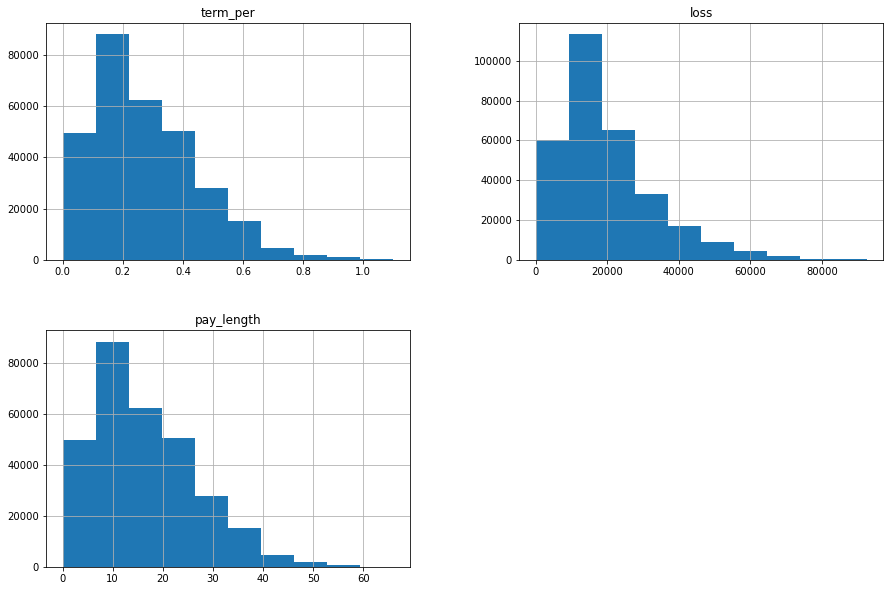

In [166]:
data[['term_per', 'loss', 'pay_length']].hist(figsize=(15,10))

# How much money would Lending Club save?

Load the data.

In [106]:
df = pd.read_csv("C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\LendingClubClean.csv")
df = df.drop(columns=['Unnamed: 0'])

Load the model

In [109]:
model = pickle.load(open("XGBoost_model", "rb"))

In [112]:
# Preprocess the data to apply model.

y = df['Status']
X = df.drop(columns=['Status', 'grade'])



ycol_name =['Status']
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
Xcol_names = X.columns
#X.set_index('id', inplace=True)
Xn = X.to_numpy()
yn = y.to_numpy()

random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)
X_res = pd.DataFrame(X_res, columns=Xcol_names)

id = X_res['id']

X_res.drop(columns='id', axis=1, inplace=True)
X_res = X_res.to_numpy()

In [ ]:
## Define a pipeline and fit the model

In [113]:
pipeXGbest = make_pipeline(MinMaxScaler(), model)
result = pipeXGbest.fit(X_res, y_res)

[10:15:13] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:15:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [114]:
y_pred = pipeXGbest.predict(X_res)

In [167]:
model_prediction = pd.concat({'loan_status': pd.Series(y_res), 'predicted_status': pd.Series(y_pred)}, axis=1)
model_prediction.index = id


In [168]:
results = model_prediction.merge(data, how='left', left_on='id', right_on='id')

In [129]:
results_saving = results.loc[(results['loan_status']=='Default') & (results['predicted_status']=='Default'), :]

In [170]:
results_saving.head()

,loan_status,predicted_status,id,loan_amnt,installment,int_rate,total_pymnt,total_rec_late_fee,pay_length,Term,expected,loss
0,Default,Default,66624733.0,18000.0,471.70,19.48,9452.74,0.00,17.0,60.0,28302.0,18849.26
1,Default,Default,67849662.0,4225.0,146.16,14.85,2558.87,0.00,16.0,60.0,8769.6,6210.73
2,Default,Default,67715283.0,16000.0,538.18,12.88,17396.63,161.46,35.0,60.0,32290.8,14894.17
3,Default,Default,68341789.0,24250.0,701.01,24.24,4124.42,0.00,7.0,60.0,42060.6,37936.18
4,Default,Default,68415473.0,25000.0,581.58,13.99,14490.92,0.00,26.0,60.0,34894.8,20403.88


In [171]:
print('Total amount Lending Club has lost is {}.'.format(data.loss.sum()))

Total amount Lending Club has lost is 5998214435.158355.


In [173]:
print('Lending Club would have saved ${} ({}% of the total loss), if they had used our model'.format(round(results_saving.loss.sum(),2),round(100*results_saving.loss.sum()/data.loss.sum(),2)))

Lending Club would have saved $3764828296.1 (62.77% of the total loss), if they had used our model
